# CNN with Pytorch 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
transform = transforms.ToTensor()
train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

100.0%


Extracting ../Data\cifar-10-python.tar.gz to ../Data
Files already downloaded and verified


In [4]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size = 10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [5]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [6]:
for images, labels in train_loader:
    break

In [8]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

Label:  [1 5 8 1 6 1 6 3 7 9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


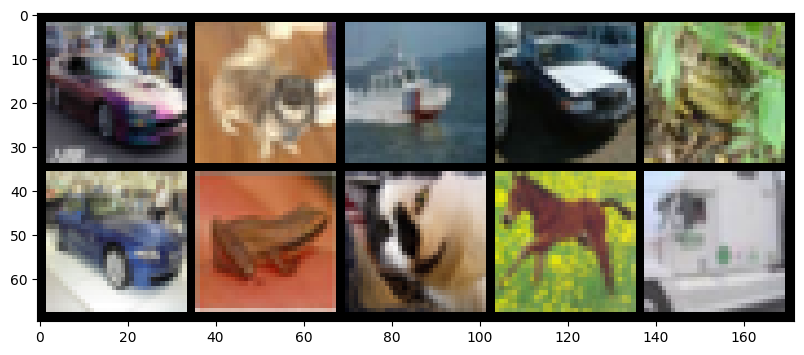

In [9]:
print('Label: ', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))
im = make_grid(images, nrow=5)
plt.figure(figsize=(10,4));
plt.imshow(np.transpose(im.numpy(), (1,2,0)));

In [10]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(6*6*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim = 1)

In [15]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [18]:
import time
start_time = time.time()

epochs = 10
train_losses = []
train_correct = []

test_losses = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%1000 == 0:
            print(f'epoch: {i:2} batch: {b:4} [{10*b:6}/50000] loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr)

    with torch.no_grad():
        for (X_test, y_test) in test_loader:
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr)


print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0 batch: 1000 [ 10000/50000] loss: 2.06749177 accuracy:  26.450%
epoch:  0 batch: 2000 [ 20000/50000] loss: 1.86101222 accuracy:  32.330%
epoch:  0 batch: 3000 [ 30000/50000] loss: 0.96922749 accuracy:  35.833%
epoch:  0 batch: 4000 [ 40000/50000] loss: 1.20704651 accuracy:  37.877%
epoch:  0 batch: 5000 [ 50000/50000] loss: 1.42030454 accuracy:  39.636%
epoch:  1 batch: 1000 [ 10000/50000] loss: 1.40712595 accuracy:  48.700%
epoch:  1 batch: 2000 [ 20000/50000] loss: 1.12186170 accuracy:  49.210%
epoch:  1 batch: 3000 [ 30000/50000] loss: 1.45328736 accuracy:  49.940%
epoch:  1 batch: 4000 [ 40000/50000] loss: 0.89537537 accuracy:  50.343%
epoch:  1 batch: 5000 [ 50000/50000] loss: 1.78368509 accuracy:  50.676%
epoch:  2 batch: 1000 [ 10000/50000] loss: 1.64881897 accuracy:  53.990%
epoch:  2 batch: 2000 [ 20000/50000] loss: 1.50339866 accuracy:  54.035%
epoch:  2 batch: 3000 [ 30000/50000] loss: 1.69832361 accuracy:  54.750%
epoch:  2 batch: 4000 [ 40000/50000] loss: 1.543672

In [ ]:
torch.save(model.state_dict(), 'myCIFARmodel.pt')

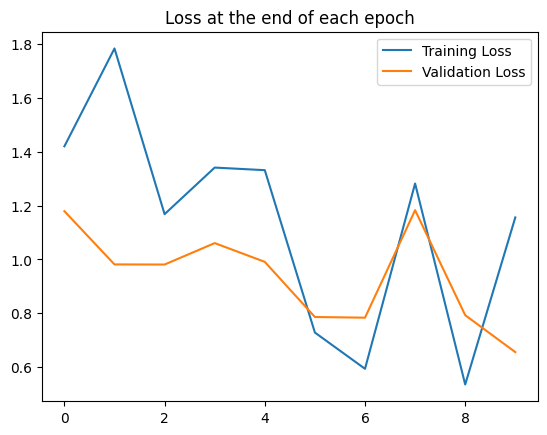

In [19]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Validation Loss')
plt.title('Loss at the end of each epoch')
plt.legend();

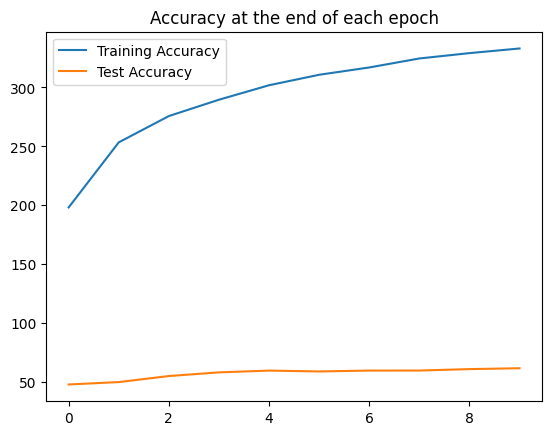

In [21]:
plt.plot([t/100 for t in train_correct], label = 'Training Accuracy')
plt.plot([t/100 for t in test_correct], label = 'Test Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [22]:
print(test_correct)

[tensor(4797), tensor(5000), tensor(5512), tensor(5825), tensor(5974), tensor(5902), tensor(5977), tensor(5980), tensor(6101), tensor(6175)]


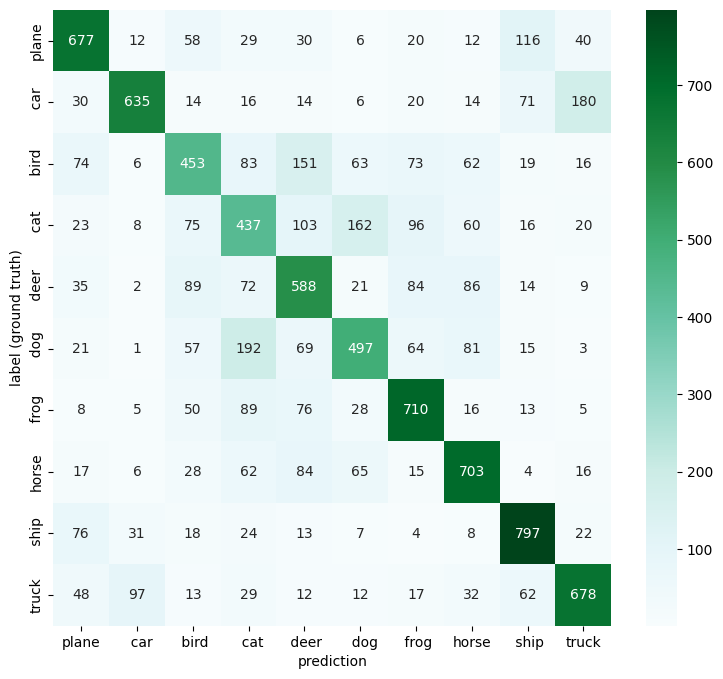

In [23]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        loss = criterion(y_val, y_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize=(9,8))
sns.heatmap(df_cm, annot = True, fmt = 'd', cmap = 'BuGn')
plt.xlabel('prediction')
plt.ylabel('label (ground truth)')
plt.show();